In [1]:
from Izh_net import *
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
from tqdm import tqdm
import os
import numpy as np
from scipy.signal import correlate
from scipy.fft import fft

# Running procedure
def run(net, flexor, extensor, T, Iapp):
    net.set_init_conditions()
    flexor.set_init_conditions()
    extensor.set_init_conditions()
    dt = T[1] - T[0]
    N = len(net)
    U = np.zeros((len(T), N))
    V = np.zeros((len(T), N))
    Cn_f = np.zeros(len(T))
    X_f = np.zeros(len(T))
    F_f = np.zeros(len(T))
    Cn_e = np.zeros(len(T))
    X_e = np.zeros(len(T))
    F_e = np.zeros(len(T))
    W = np.zeros(len(T))
    Q = np.zeros(len(T))
    for i, t in enumerate(T):
        U[i] = net.U_prev
        V[i] = net.V_prev
        Cn_f[i] = flexor.Cn_prev
        X_f[i] = flexor.x
        F_f[i] = flexor.F_prev
        Cn_e[i] = extensor.Cn_prev
        X_e[i] = extensor.x
        F_e[i] = extensor.F_prev
        net.step(dt=dt, Iapp=Iapp(t))
        uf = net.output[0]
        ue = net.output[1]
        flexor.step(dt=dt, u=uf)
        extensor.step(dt=dt, u=ue)
    return U, V, Cn_f, X_f, F_f, Cn_e, X_e, F_e

In [2]:
def calc_T(T, signal):    
    mean = np.mean(signal)
    mean_idx = np.where(np.logical_and(signal[1:]>=mean, signal[:-1]<=mean))
    plt.scatter(T[mean_idx], signal[mean_idx], color='m')
    plt.axhline(mean)
    T = np.mean(np.diff(T[mean_idx]))
    return T

def calc_df(T, signal1, signal2):
    # Вычисление кросс-корреляции
    correlation = correlate(signal1, signal2, mode='full')
    period = calc_T(T, signal1)
    # Нахождение индекса максимальной корреляции
    lag = np.argmax(correlation) - (len(signal1) - 1)

    # Вычисление временной задержки
    time_delay = lag * (T[1] - T[0])

    # Вычисление разности фаз
    phase_difference = 2 * np.pi * 1/period * time_delay  # Умножаем на частоту сигнала
    return phase_difference

  0%|                                                    | 0/20 [00:00<?, ?it/s]

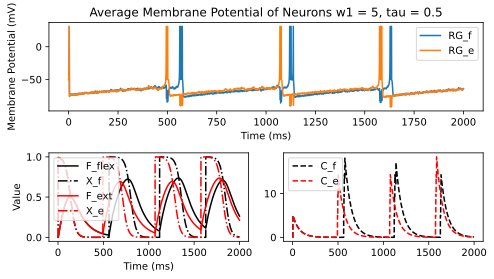

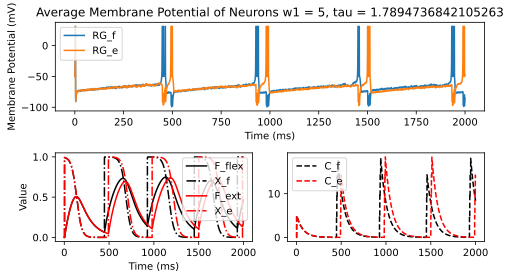

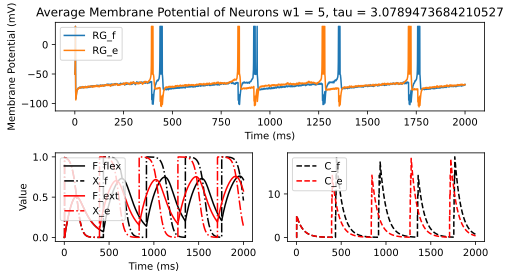

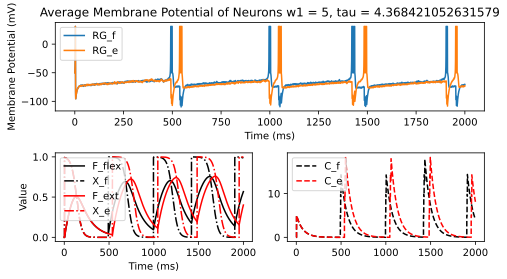

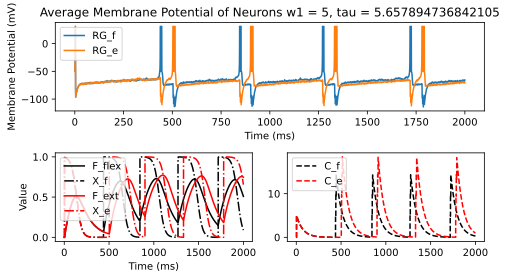

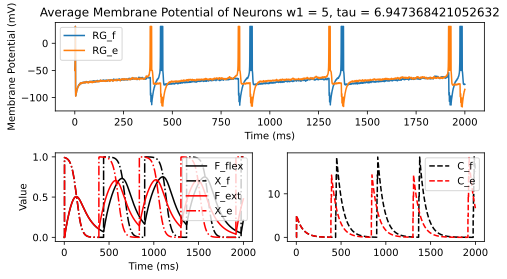

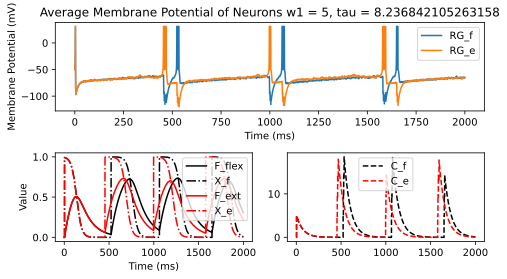

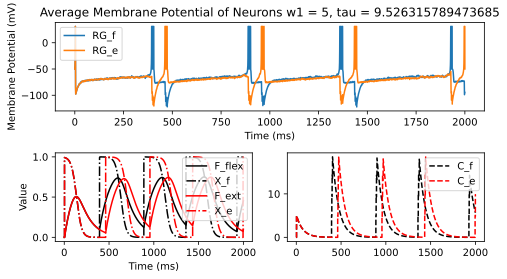

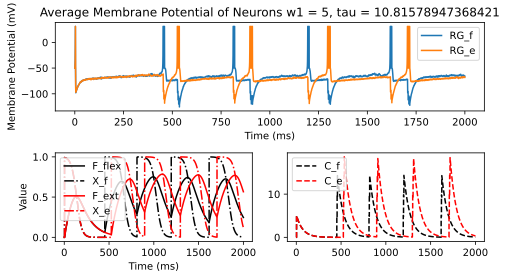

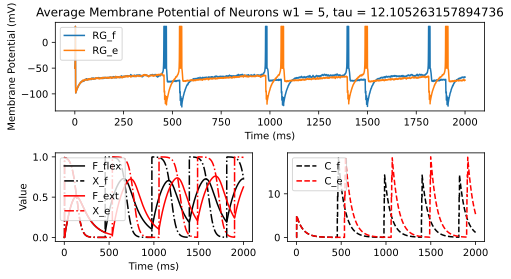

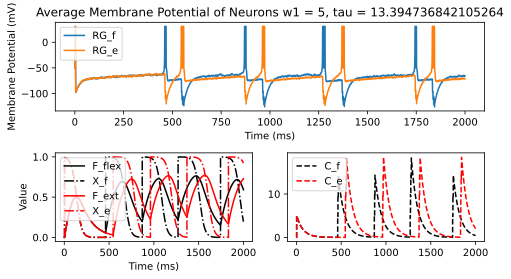

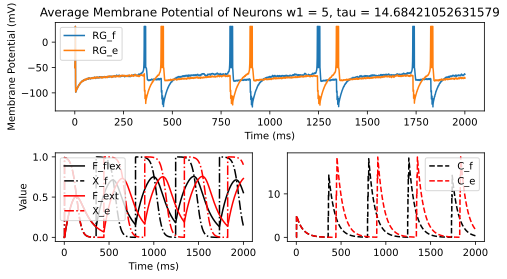

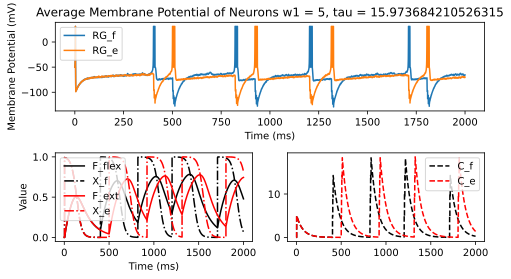

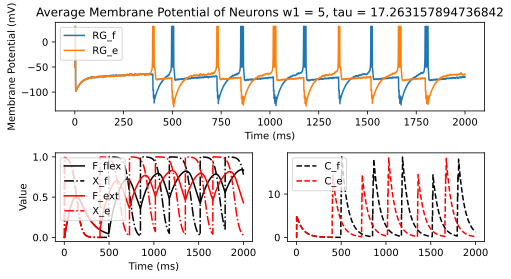

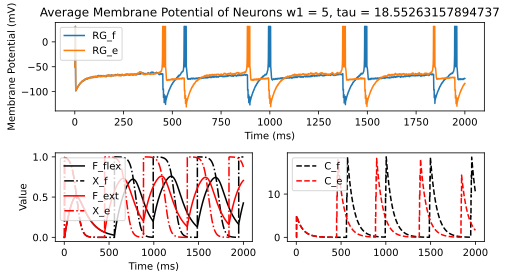

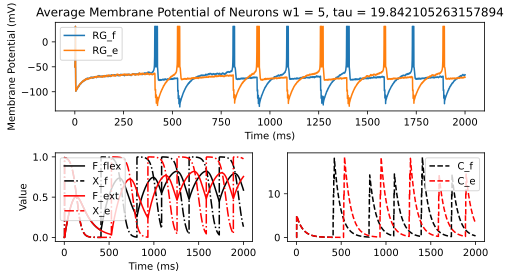

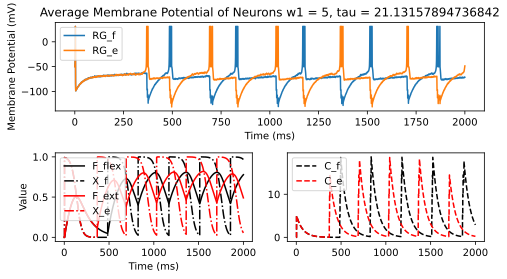

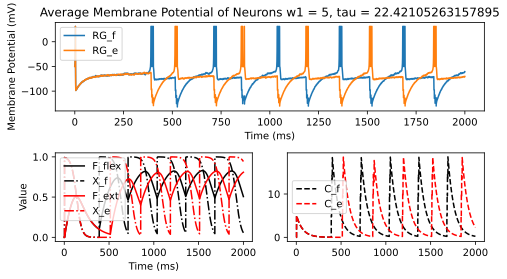

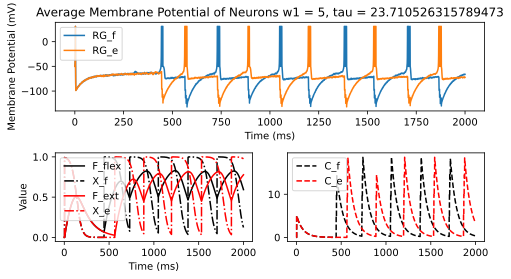

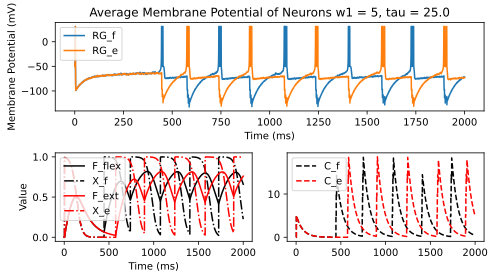

  0%|                                                    | 0/20 [00:05<?, ?it/s]


In [3]:
from scipy.signal import correlate
# Creating network
# Creating network
N = 2
a = 0.004
b = 0.26
c = -50
d = 2
A = a*np.ones(N)
B = b*np.ones(N)
C = c*np.ones(N)
D = d*np.ones(N)
net = Izhikevich_Network(N=N, a=A, b=B, c=C, d=D)
net.names=["RG_f", "RG_e"]
net.M = np.array([
            [0, 1],
            [1, 0],
        ])

# Limb settings
flexor = SimpleAdaptedMuscle(N=1, w=0.5)
extensor = SimpleAdaptedMuscle(N=1, w=0.5)
    
I = np.zeros(N)
I[0] = 0.1
I[1] = 0
input = lambda t: I + np.random.normal(size=N)
# prepare simulations
T_max = 2000
time_scale = 3
T = np.linspace(0, T_max, T_max*time_scale)
dt = T[1]-T[0]

# Set the random seed for reproducibility
np.random.seed(2000)

# Define the parameter sets for each Q
w=5
tau_values = np.linspace(0.5, 25, 20)

# Accumulate results
results = []

# Accumulate results
Max_proc = len(tau_values)
with tqdm(total=Max_proc) as pbar:
        for K, tau in enumerate(tau_values):
                net.set_weights(np.array([
                        [0, -w],
                        [-w, 0],
                    ])
                    )
            
                net.set_synaptic_relax_constant(
                        np.array(
                        [
                            [1, tau],
                            [tau, 1],
                        ]
                        )
                    )
                U, V, Cn_f, X_f, F_f, Cn_e, X_e, F_e = run(net, flexor, extensor, T, input)
                # Visualization
                plt.figure(figsize=(7, 4))
        
                plt.subplot(211)
                for i in range(N):
                    plt.plot(T, V[:, i], label=f"{net.names[i]}")
                plt.xlabel('Time (ms)')
                plt.ylabel('Membrane Potential (mV)')
                plt.title(f'Average Membrane Potential of Neurons w1 = {w}, tau = {tau}')
                plt.legend()
        

        
                plt.subplot(2, 2, 3)
                plt.plot(T, F_f, label="F_flex", color='k')
                plt.plot(T, X_f, label="X_f", color='k', linestyle='-.')
                plt.plot(T, F_e, label="F_ext", color='r')
                plt.plot(T, X_e, label="X_e", color='r', linestyle='-.')
                plt.xlabel('Time (ms)')
                plt.ylabel('Value')
                plt.legend()
                plt.subplot(224)
                plt.plot(T, Cn_f, label="C_f", color='k', linestyle='--')
                plt.plot(T, Cn_e, label="C_e", color='r', linestyle='--')      
                plt.legend()
                plt.tight_layout()
                plt.show()